In [7]:
import os

# Masukkan Username dan Key Kaggle Anda di sini
os.environ['KAGGLE_USERNAME'] = "ahadanfauzan" # Cek di profil Kaggle Anda
os.environ['KAGGLE_KEY'] = "KGAT_78ed717ea7f0fe949ad00912fbdc3716"



print("Log: API Kaggle berhasil dikonfigurasi menggunakan Environment Variables.")

Log: API Kaggle berhasil dikonfigurasi menggunakan Environment Variables.


In [9]:
from google.colab import drive
import os

# Menghubungkan Google Drive
drive.mount('/content/drive')

# Membuat folder khusus proyek di GDrive agar rapi
path_proyek = "/content/drive/MyDrive/HandSpeak_FER"
if not os.path.exists(path_proyek):
    os.makedirs(path_proyek)
    print(f"Folder proyek berhasil dibuat di: {path_proyek}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder proyek berhasil dibuat di: /content/drive/MyDrive/HandSpeak_FER


In [10]:
!pip install kagglehub -q

import kagglehub
import os

os.environ['KAGGLE_USERNAME'] = "ahadanfauzan" # Cek di profil Kaggle Anda
os.environ['KAGGLE_KEY'] = "KGAT_78ed717ea7f0fe949ad00912fbdc3716"

print("Log: kagglehub siap digunakan.")

Log: kagglehub siap digunakan.


In [11]:
import shutil

# 1. Download dataset menggunakan kagglehub
print("Sedang mengunduh DAiSEE via kagglehub... (Harap tunggu, proses ini memakan waktu)")
path_download = kagglehub.dataset_download("olgaparfenova/daisee")

print(f"Dataset berhasil diunduh ke lokasi sementara: {path_download}")

# 2. Pindahkan ke Google Drive (Pastikan kuota GDrive cukup!)
print("Memindahkan dataset ke Google Drive...")
target_gdrive = "/content/drive/MyDrive/HandSpeak_FER/dataset_daisee"

if not os.path.exists(target_gdrive):
    shutil.move(path_download, target_gdrive)
    print(f"Dataset kini tersimpan permanen di GDrive: {target_gdrive}")
else:
    print("Dataset sudah ada di Google Drive.")

Sedang mengunduh DAiSEE via kagglehub... (Harap tunggu, proses ini memakan waktu)


100%|██████████| 14.3G/14.3G [02:06<00:00, 122MB/s]

Extracting files...


Dataset berhasil diunduh ke lokasi sementara: /root/.cache/kagglehub/datasets/olgaparfenova/daisee/versions/1
Memindahkan dataset ke Google Drive...
Dataset kini tersimpan permanen di GDrive: /content/drive/MyDrive/HandSpeak_FER/dataset_daisee


Folder Preparation

In [12]:
import os

# Lokasi dataset di GDrive Anda
base_path = "/content/drive/MyDrive/HandSpeak_FER/dataset_daisee"
output_dir = "/content/drive/MyDrive/HandSpeak_FER/processed_images"

# Membuat folder kategori emosi
emotions = ['Bengong', 'Bingung', 'Positif', 'Pusing']
for emo in emotions:
    os.makedirs(os.path.join(output_dir, emo), exist_ok=True)

print("Log: Folder kategori berhasil disiapkan di GDrive.")

Log: Folder kategori berhasil disiapkan di GDrive.


Pre-processing

In [16]:
import pandas as pd
import os

# Gunakan path yang Anda berikan
base_path = "/content/drive/MyDrive/HandSpeak_FER/dataset_daisee/DAiSEE"
csv_path = os.path.join(base_path, "Labels/TrainLabels.csv")

if os.path.exists(csv_path):
    df_check = pd.read_csv(csv_path)
    print("Daftar Kolom yang Terdeteksi:")
    print(df_check.columns.tolist())

    # Menampilkan 5 baris pertama untuk verifikasi data
    display(df_check.head())
else:
    print("File CSV tidak ditemukan pada path tersebut.")

Daftar Kolom yang Terdeteksi:
['ClipID', 'Boredom', 'Engagement', 'Confusion', 'Frustration ']


,ClipID,Boredom,Engagement,Confusion,Frustration
0,1100011002.avi,0,2,0,0
1,1100011003.avi,0,2,0,0
2,1100011004.avi,0,3,0,0
3,1100011005.avi,0,3,0,0
4,1100011006.avi,0,3,0,0


In [ ]:
import os

# Cek apakah folder video benar-benar berisi file mp4
video_root = "/content/drive/MyDrive/HandSpeak_FER/dataset_daisee/DAiSEE/DataSet/Train"

if os.path.exists(video_root):
    all_files = []
    for root, dirs, files in os.walk(video_root):
        for file in files:
            if file.endswith(".mp4"):
                all_files.append(os.path.join(root, file))

    print(f"✅ Berhasil menemukan {len(all_files)} file video .mp4")
    if len(all_files) > 0:
        print(f"Contoh path: {all_files[0]}")
else:
    print(f"❌ ERROR: Folder {video_root} tidak ditemukan. Periksa kembali penulisan 'HandSpeak_FER' atau 'DAiSEE'!")

In [27]:
import cv2
import pandas as pd
from tqdm import tqdm
import os

# --- KONFIGURASI ---
base_path = "/content/drive/MyDrive/HandSpeak_FER/dataset_daisee/DAiSEE"
video_root = os.path.join(base_path, "DataSet/Train")
csv_path = os.path.join(base_path, "Labels/TrainLabels.csv")
output_dir = "/content/train_processed_local"

# 1. Mapping Lokasi Video (Indexing) untuk Kecepatan
print("Sedang memetakan lokasi video... (Indexing)")
video_map = {}
for root, dirs, files in os.walk(video_root):
    for file in files:
        if file.endswith(".mp4"):
            video_map[file] = os.path.join(root, file)

# 2. Baca CSV dan Bersihkan Kolom
df = pd.read_csv(csv_path)
df.columns = [c.strip().lower() for c in df.columns]

# Buat folder kategori di lokal
categories = ['Bengong', 'Bingung', 'Positif', 'Pusing']
for cat in categories:
    os.makedirs(os.path.join(output_dir, cat), exist_ok=True)

# 3. Proses Ekstraksi
print(f"Memulai ekstraksi dari {len(df)} baris data...")
count_success = 0

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Mapping emosi (Gunakan nama kolom yang sudah di-clean)
    labels = {
        'Bengong': row['boredom'],
        'Bingung': row['confusion'],
        'Positif': row['engagement'],
        'Pusing': row['frustration']
    }
    top_emotion = max(labels, key=labels.get)
    if labels[top_emotion] == 0: continue

    # DAiSEE terkadang menggunakan angka murni di ClipID
    video_id = str(row['clipid'])
    video_filename = video_id if video_id.endswith(".mp4") else video_id + ".mp4"

    if video_filename in video_map:
        cap = cv2.VideoCapture(video_map[video_filename])
        # Ambil frame pada detik ke-5
        cap.set(cv2.CAP_PROP_POS_MSEC, 5000)
        ret, frame = cap.read()

        if ret:
            frame = cv2.resize(frame, (64, 64)) # Resolusi sesuai model tangan
            save_path = os.path.join(output_dir, top_emotion, f"{video_id}.jpg")
            cv2.imwrite(save_path, frame)
            count_success += 1
        cap.release()

print(f"\n✅ SELESAI! Berhasil mengekstrak {count_success} gambar ke {output_dir}")

Sedang memetakan lokasi video... (Indexing)
Memulai ekstraksi dari 5358 baris data...


100%|██████████| 5358/5358 [01:16<00:00, 69.87it/s]


✅ SELESAI! Berhasil mengekstrak 506 gambar ke /content/train_processed_local


Data Augmented

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfigurasi Augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Mengatasi kemiringan kepala
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,   # Mengatasi arah hadap wajah
    fill_mode='nearest',
    validation_split=0.2    # Split 80:20 untuk training dan validasi
)

# Generator untuk Training
train_generator = datagen.flow_from_directory(
    "/content/train_processed_local",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Generator untuk Validasi
val_generator = datagen.flow_from_directory(
    "/content/train_processed_local",
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Kelas terdeteksi: {train_generator.class_indices}")

Found 406 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Kelas terdeteksi: {'Bengong': 0, 'Bingung': 1, 'Positif': 2, 'Pusing': 3}


Arsitektur Model

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers

def build_fer_model():
    # Base model MobileNetV2 yang ringan untuk real-time
    base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
    base_model.trainable = False # Bekukan awal untuk stabilitas

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5), # Anti-overfitting ekstrem
        layers.Dense(4, activation='softmax') # 4 Kelas: Bengong, Bingung, Positif, Pusing
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_fer = build_fer_model()
model_fer.summary()

/tmp/ipython-input-143595967.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,956 (11.13 MB)

 Trainable params: 658,948 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

Training

In [31]:
import os

path_lokal = "/content/train_processed_local"

if os.path.exists(path_lokal):
    print("--- Laporan Ketersediaan Data ---")
    folders = [f for f in os.listdir(path_lokal) if os.path.isdir(os.path.join(path_lokal, f))]
    total_files = 0
    for folder in folders:
        num_files = len(os.listdir(os.path.join(path_lokal, folder)))
        total_files += num_files
        print(f"Folder {folder}: {num_files} gambar ditemukan")

    if total_files == 0:
        print("\n❌ ERROR: Tidak ada gambar di dalam folder! Jalankan ulang sel Preprocessing.")
    else:
        print(f"\n✅ TOTAL: {total_files} gambar siap dilatih.")
else:
    print("❌ ERROR: Folder '/content/train_processed_local' tidak ditemukan!")

--- Laporan Ketersediaan Data ---
Folder Bingung: 18 gambar ditemukan
Folder Pusing: 2 gambar ditemukan
Folder Positif: 455 gambar ditemukan
Folder Bengong: 31 gambar ditemukan

✅ TOTAL: 506 gambar siap dilatih.


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# 1. Verifikasi akhir sebelum running
if len(train_generator) == 0:
    print("❌ ERROR: Data training kosong. Pastikan sel Preprocessing sudah selesai!")
else:
    # 2. Konfigurasi Callback
    # Berhenti jika val_loss tidak membaik dalam 5 epoch
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_fer_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    print("🚀 Memulai pelatihan model emosi FER...")
    # Menggunakan generator yang sudah dibuat
    history = model_fer.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    print("✅ Pelatihan Selesai!")

🚀 Memulai pelatihan model emosi FER...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2663 - loss: 9.2276
Epoch 1: val_accuracy improved from -inf to 0.22000, saving model to best_fer_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.2678 - loss: 9.1942 - val_accuracy: 0.2200 - val_loss: 7.7786
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3179 - loss: 7.6565
Epoch 2: val_accuracy improved from 0.22000 to 0.59000, saving model to best_fer_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.3204 - loss: 7.6354 - val_accuracy: 0.5900 - val_loss: 6.0996
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4118 - loss: 6.5455
Epoch 3: val_accuracy did not improve from 0.59000
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.4132 - loss: 6.5311 - val_accuracy: 0.4200 - val_loss: 5.9717
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5356 - loss: 5.5822
Epoch 4: val_accuracy improved from 0.59000 to 0.76000, saving model to best_fe

Visualisasi Performa Model

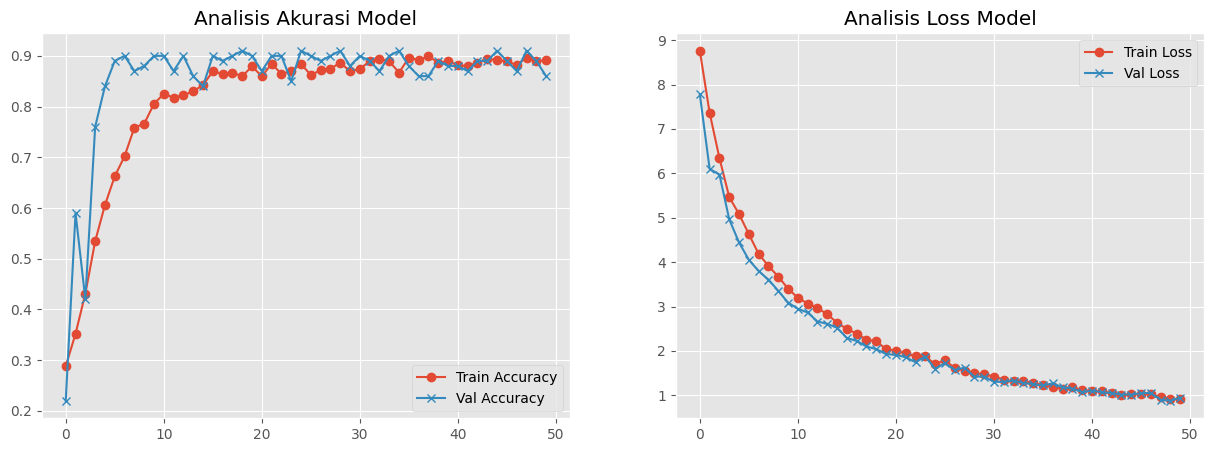

In [33]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Akurasi
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
ax1.set_title('Analisis Akurasi Model')
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='x')
ax2.set_title('Analisis Loss Model')
ax2.legend()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


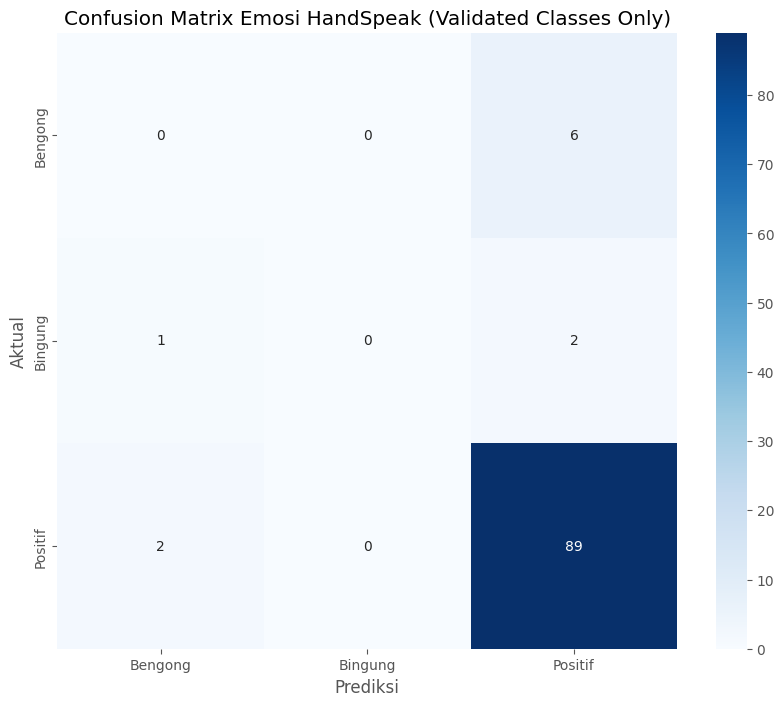


--- Laporan Klasifikasi (Classification Report) ---
              precision    recall  f1-score   support

     Bengong       0.00      0.00      0.00         6
     Bingung       0.00      0.00      0.00         3
     Positif       0.92      0.98      0.95        91

    accuracy                           0.89       100
   macro avg       0.31      0.33      0.32       100
weighted avg       0.83      0.89      0.86       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Reset generator dan ambil prediksi
val_generator.reset()
Y_pred = model_fer.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# 2. Ambil label kelas yang BENAR-BENAR ada di data validasi
# Ini penting karena jika ada kelas yang kosong, report tidak akan error lagi
actual_classes = np.unique(val_generator.classes)
detected_class_names = [list(train_generator.class_indices.keys())[i] for i in actual_classes]

# 3. Plotting Confusion Matrix
cm = confusion_matrix(val_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=detected_class_names,
            yticklabels=detected_class_names,
            cmap='Blues')
plt.title('Confusion Matrix Emosi HandSpeak (Validated Classes Only)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# 4. Print Classification Report dengan label yang sesuai
print("\n--- Laporan Klasifikasi (Classification Report) ---")
print(classification_report(val_generator.classes,
                            y_pred,
                            target_names=detected_class_names))

In [36]:
# Tentukan path penyimpanan di Drive Anda
drive_save_path = "/content/drive/MyDrive/HandSpeak_FER/fer_emotion_model_v1.keras"

# Simpan model
model_fer.save(drive_save_path)
print(f"Model berhasil disimpan secara permanen di: {drive_save_path}")

Model berhasil disimpan secara permanen di: /content/drive/MyDrive/HandSpeak_FER/fer_emotion_model_v1.keras
